In [ ]:
!pip install llama-index langchain-community llama-index-llms-gemini langgraph langchain-google-genai

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from llama_index.core.tools import FunctionTool
from llama_index.llms.gemini import Gemini
from llama_index.core.agent import ReActAgent
from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import AzureChatOpenAI

In [ ]:
from google.colab import userdata

api_key = userdata.get('GOOGLE_API_KEY')

In [ ]:
# Set API Key
csv_path = '/content/combined_file.csv'  # Update with your CSV path
# Initialize LLM
llm = ChatGoogleGenerativeAI(model="models/gemini-1.5-flash-latest", google_api_key=api_key)

In [ ]:
print(
    llm.invoke(
        "What are some of the pros and cons of Python as a programming language?"
    )
)

content='Python is a hugely popular programming language, but like any language, it has its strengths and weaknesses.\n\n**Pros:**\n\n* **Readability and Ease of Use:** Python\'s syntax is clear, concise, and emphasizes readability.  This makes it easier to learn, especially for beginners, and reduces development time.  The code is often described as "almost like plain English."\n* **Large and Active Community:** A massive community provides extensive support, numerous libraries, and frameworks.  If you encounter a problem, chances are someone else has already solved it and shared the solution online.\n* **Extensive Libraries and Frameworks:**  Python boasts a rich ecosystem of libraries for almost any task imaginable, from web development (Django, Flask) to data science (NumPy, Pandas, Scikit-learn) to machine learning (TensorFlow, PyTorch) and more. This saves developers significant time and effort.\n* **Versatility:** Python is used in a wide range of applications, including web dev

#Set Prompt

In [ ]:
default_router_prompt = """
You are an AI assistant that acts as a router in a chain of llms.
Your task is to classify whether the user's question
is GENERAL (can be answered with broad, common knowledge) or
CSV-RELATED (requires specialized knowledge or information from a csv file).

---------------
Contraints:
---------------
- Do not answer the question. Only classify the question to one of the given categories
- Return ONLY 'GENERAL' or 'CSV-RELATED'.
- Do NOT provide any explanation. Only the specified keyword should be returned.
"""

default_chat_prompt = """
You are a knowledgeable and helpful assistant.
Your task is to answer the given question based on the following summary of the available information:
Here is a summary of the information provided to you:
{messages}

---------------
Contraints:
---------------
- Make sure to integrate the provided information if it's relevant.
- Integrate additional insights if it is known by you.
- Answer clearly, accurate and helpful.
"""

default_csv_related_prompt = """
You are an assistant tasked with gathering specific information to help answer a question.
Your task is to:
1. Calculate sum of a column. Use when user asks for total or summation.
2. Compare averages of two columns. Use for comparison requests.
3. Generate bar chart for a column. Use when visualization is requested.

To provide a complete response, you need to use the following tools to find additional information:
{tool_names}.CSV path is {csv_path}.

---------------
Contraints:
---------------
- Anwer clearly and relevant to the user's query.
- The answer have to be ready for the chat node to integrate into the final answer

"""

#Create Agent

In [ ]:
from typing import Any, Union, List, Dict
from langgraph.graph.state import CompiledStateGraph
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables.base import RunnableSequence
from langchain_core.messages import AIMessage, ToolMessage, HumanMessage

In [ ]:
def create_agent(
    llm: ChatGoogleGenerativeAI, default_prompt: str, tools: List = [], csv_path=csv_path
) -> RunnableSequence:
    """
    Create an agent with the provided prompt.
    If no tools are specified, the agent will be created without them.
    """
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", default_prompt),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    prompt = prompt.partial(csv_path=csv_path)

    if tools:
        chain = prompt | llm.bind_tools([tool.func for tool  in tools])
    else:
        chain = prompt | llm

    return chain  # type: ignore

In [ ]:
class CSV_tool:
  def __init__(self, name, func):
    self.name = name
    self.func=func

def sum_column(column: str, csv_path=csv_path) -> str:
    """Calculate sum of a column. Use when user asks for total or summation."""
    df = pd.read_csv(csv_path)
    if column not in df.columns:
        return f"Error: Column '{column}' not found"
    return f"The sum of {column} is {df[column].sum()}"

def compare_columns(col1: str, col2: str, csv_path=csv_path) -> str:
    """Compare averages of two columns. Use for comparison requests."""
    df = pd.read_csv(csv_path)
    for col in [col1, col2]:
        if col not in df.columns:
            return f"Error: Column '{col}' not found"
    avg1, avg2 = df[col1].mean(), df[col2].mean()
    return f"Average: {col1}={avg1:.2f}, {col2}={avg2:.2f}. {'Higher' if avg1 > avg2 else 'Lower'} column: {col1 if avg1 > avg2 else col2}"

def plot_column(column: str, csv_path=csv_path) -> str:
    """Generate bar chart for a column. Use when visualization is requested."""
    df = pd.read_csv(csv_path)
    if column not in df.columns:
        return f"Error: Column '{column}' not found"
    plt.figure(figsize=(10,4))
    df[column].plot(kind='bar')
    plt.title(f"Distribution of {column}")
    plt.savefig('plot.png')
    plt.close()
    return "Chart saved to plot.png"

sum_column_tool = CSV_tool(name="sum_column", func=sum_column)
compare_columns_tool = CSV_tool(name="compare_columns", func=compare_columns)
plot_column_tool = CSV_tool(name="plot_column", func=plot_column)

In [ ]:
classifier_agent = create_agent(llm, default_router_prompt)
chat_agent = create_agent(llm, default_chat_prompt)
csv_process_agent = create_agent(
    llm,
    default_csv_related_prompt,
    tools = [sum_column_tool, compare_columns_tool, plot_column_tool]
)

#Create Node

In [ ]:
import functools
import operator
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.prebuilt import ToolNode



In [ ]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

def agent_node(state: AgentState, agent: RunnableSequence, name: str, csv_path=csv_path) -> AgentState:
    result = agent.invoke(state)
    # If the result is from a tool, ensure it's wrapped as a ToolMessage
    if isinstance(result, ToolMessage):
        # Keep the ToolMessage as is and pass it through
        result_message = result
    else:
        # Otherwise, convert it to an AIMessage
        result_message = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        # "messages": state["messages"] + [result_message],
        "messages": [result_message],
        "sender": name,
        "csv_path": csv_path
    }


In [ ]:
classifier_node = functools.partial(
    agent_node, agent=classifier_agent, name="classifier"
)
chat_node = functools.partial(agent_node, agent=chat_agent, name="chat")
csv_process_node = functools.partial(
    agent_node, agent=csv_process_agent, name="csv_process"
)

In [ ]:
tools = [sum_column, compare_columns, plot_column]
tool_node = ToolNode(tools)

#Create Graph

In [ ]:
from langgraph.graph import END, StateGraph
from typing import Literal

In [ ]:
def classifier_router(state: AgentState) -> Literal["CSV-RELATED", "GENERAL"]:
    """
    Router to use in conditional edges after the results of the classifier agent.
    """
    last_message = state["messages"][-1]
    if "CSV" in last_message.content:
        # An agent decided the work is done
        return "CSV-RELATED"
    elif "GENERAL" in last_message.content:
        return "GENERAL"
    raise Exception("The message did'nt contain SPECIFIC OR GENERAL keywords.")

In [ ]:
# Define the Graph Workflow
workflow = StateGraph(AgentState)

# Add Nodes to the Workflow
workflow.add_node("classifier", classifier_node)
workflow.add_node("chat", chat_node)
workflow.add_node("csv_process", csv_process_node)
workflow.add_node("tool", tool_node)

# Define Edges
workflow.add_conditional_edges(
    "classifier",
    classifier_router,
    {"CSV-RELATED": "csv_process", "GENERAL": "chat"},
)

workflow.add_edge("csv_process", "tool")
workflow.add_edge("tool", "chat")
workflow.add_edge("chat", END)

# Set Entry Point
workflow.set_entry_point("classifier")

# Compile the Graph
graph = workflow.compile()

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

In [ ]:
# Initialize memory to persist memory between graph runs
checkpointer = MemorySaver()
graph = workflow.compile(debug=True, checkpointer=checkpointer)

#Result

In [ ]:
from pprint import pprint


In [ ]:
def invoke_graph(
    graph: CompiledStateGraph, messages: str | List[str], thread_id: str = "1"
) -> Union[Dict[str, Any], Any]:
    configured_messages = [HumanMessage(content=messages)]
    config = {"configurable": {"thread_id": thread_id}}
    result = graph.invoke(input={"messages": configured_messages}, config=config)
    return result["messages"][-1].content

In [ ]:
result = invoke_graph(graph=graph, messages="what is python?")
pprint(result)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [HumanMessage(content='what is python?', additional_kwargs={}, response_metadata={})]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [HumanMessage(content='what is python?', additional_kwargs={}, response_metadata={})]
[0:checkpoint] State at the end of step 0:
{'messages': [HumanMessage(content='what is python?', additional_kwargs={}, response_metadata={})]}
[1:tasks] Starting 1 task for step 1:
- classifier -> {'messages': [HumanMessage(content='what is python?', additional_kwargs={}, response_metadata={})]}


<ipython-input-127-7e25ff4659ed>:13: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  result_message = AIMessage(**result.dict(exclude={"type", "name"}), name=name)


[1:writes] Finished step 1 with writes to 2 channels:
- messages -> [AIMessage(content='GENERAL', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, name='classifier', id='run--f9f67bb7-c018-45ba-b57a-bdc2b99cfc9e-0', usage_metadata={'input_tokens': 119, 'output_tokens': 2, 'total_tokens': 121, 'input_token_details': {'cache_read': 0}})]
- sender -> 'classifier'
[1:checkpoint] State at the end of step 1:
{'messages': [HumanMessage(content='what is python?', additional_kwargs={}, response_metadata={}),
              AIMessage(content='GENERAL', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, name='classifier', id='run--f9f67bb7-c018-45ba-b57a-bdc2b99cfc9e-0', usage_metadata={'input_tokens': 119, 'output_tokens': 2, 'total_tokens': 121, 'input_token_details': {'cache_read': 0}})],
 'sende

<ipython-input-127-7e25ff4659ed>:13: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  result_message = AIMessage(**result.dict(exclude={"type", "name"}), name=name)


In [ ]:
result = invoke_graph(graph=graph, messages="what is the summation of column likes?")
pprint(result)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [HumanMessage(content='what is the summation of column likes?', additional_kwargs={}, response_metadata={})]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [HumanMessage(content='what is the summation of column likes?', additional_kwargs={}, response_metadata={})]
[0:checkpoint] State at the end of step 0:
{'messages': [HumanMessage(content='what is the summation of column likes?', additional_kwargs={}, response_metadata={})]}
[1:tasks] Starting 1 task for step 1:
- classifier -> {'messages': [HumanMessage(content='what is the summation of column likes?', additional_kwargs={}, response_metadata={})]}


<ipython-input-151-47914fa30c15>:13: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  result_message = AIMessage(**result.dict(exclude={"type", "name"}), name=name)


[1:writes] Finished step 1 with writes to 2 channels:
- messages -> [AIMessage(content='CSV-RELATED', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, name='classifier', id='run--6f84fd8a-264d-4c35-9af4-bf96a451f150-0', usage_metadata={'input_tokens': 123, 'output_tokens': 4, 'total_tokens': 127, 'input_token_details': {'cache_read': 0}})]
- sender -> 'classifier'
[1:checkpoint] State at the end of step 1:
{'messages': [HumanMessage(content='what is the summation of column likes?', additional_kwargs={}, response_metadata={}),
              AIMessage(content='CSV-RELATED', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, name='classifier', id='run--6f84fd8a-264d-4c35-9af4-bf96a451f150-0', usage_metadata={'input_tokens': 123, 'output_tokens': 4, 'total_tokens': 127, 'input_token_details'

<ipython-input-151-47914fa30c15>:13: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  result_message = AIMessage(**result.dict(exclude={"type", "name"}), name=name)


[2:writes] Finished step 2 with writes to 2 channels:
- messages -> [AIMessage(content='', additional_kwargs={'function_call': {'name': 'sum_column', 'arguments': '{"csv_path": "/content/combined_file.csv", "column": "likes"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, name='csv_process', id='run--8ec2f9e1-d9de-41b4-83af-319231a39fa5-0', tool_calls=[{'name': 'sum_column', 'args': {'csv_path': '/content/combined_file.csv', 'column': 'likes'}, 'id': '389a50ef-5d3f-4494-83e5-3bfc6499097e', 'type': 'tool_call'}], usage_metadata={'input_tokens': 242, 'output_tokens': 16, 'total_tokens': 258, 'input_token_details': {'cache_read': 0}})]
- sender -> 'csv_process'
[2:checkpoint] State at the end of step 2:
{'messages': [HumanMessage(content='what is the summation of column likes?', additional_kwargs={}, response_metadata={}),
              AIMessage(content='CSV-RELATED', additional_kwargs={}, response_meta

<ipython-input-151-47914fa30c15>:13: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  result_message = AIMessage(**result.dict(exclude={"type", "name"}), name=name)


In [ ]:
result = invoke_graph(graph=graph, messages="Plot column likes")
pprint(result)

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [HumanMessage(content='Plot column likes', additional_kwargs={}, response_metadata={})]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [HumanMessage(content='Plot column likes', additional_kwargs={}, response_metadata={})]
[0:checkpoint] State at the end of step 0:
{'messages': [HumanMessage(content='Plot column likes', additional_kwargs={}, response_metadata={})]}
[1:tasks] Starting 1 task for step 1:
- classifier -> {'messages': [HumanMessage(content='Plot column likes', additional_kwargs={}, response_metadata={})]}


<ipython-input-171-47914fa30c15>:13: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  result_message = AIMessage(**result.dict(exclude={"type", "name"}), name=name)


[1:writes] Finished step 1 with writes to 2 channels:
- messages -> [AIMessage(content='CSV-RELATED', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, name='classifier', id='run--56a2afc7-d253-40c5-bbd6-f950fb907955-0', usage_metadata={'input_tokens': 118, 'output_tokens': 4, 'total_tokens': 122, 'input_token_details': {'cache_read': 0}})]
- sender -> 'classifier'
[1:checkpoint] State at the end of step 1:
{'messages': [HumanMessage(content='Plot column likes', additional_kwargs={}, response_metadata={}),
              AIMessage(content='CSV-RELATED', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, name='classifier', id='run--56a2afc7-d253-40c5-bbd6-f950fb907955-0', usage_metadata={'input_tokens': 118, 'output_tokens': 4, 'total_tokens': 122, 'input_token_details': {'cache_read': 0}})

<ipython-input-171-47914fa30c15>:13: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  result_message = AIMessage(**result.dict(exclude={"type", "name"}), name=name)


[2:writes] Finished step 2 with writes to 2 channels:
- messages -> [AIMessage(content='', additional_kwargs={'function_call': {'name': 'plot_column', 'arguments': '{"csv_path": "/content/combined_file.csv", "column": "likes"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, name='csv_process', id='run--ce59d8df-1cd7-4383-8a02-19eade9ec24e-0', tool_calls=[{'name': 'plot_column', 'args': {'csv_path': '/content/combined_file.csv', 'column': 'likes'}, 'id': '4823d5ec-143a-4a34-8f02-6841b77c47c7', 'type': 'tool_call'}], usage_metadata={'input_tokens': 237, 'output_tokens': 16, 'total_tokens': 253, 'input_token_details': {'cache_read': 0}})]
- sender -> 'csv_process'
[2:checkpoint] State at the end of step 2:
{'messages': [HumanMessage(content='Plot column likes', additional_kwargs={}, response_metadata={}),
              AIMessage(content='CSV-RELATED', additional_kwargs={}, response_metadata={'prompt_feedb

<ipython-input-171-47914fa30c15>:13: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  result_message = AIMessage(**result.dict(exclude={"type", "name"}), name=name)


In [ ]:
# Cài Graphviz và các thư viện phát triển
!apt-get install -y graphviz libgraphviz-dev pkg-config

# Cài pygraphviz từ source và chỉ định rõ đường dẫn Graphviz
!pip install pygraphviz --no-binary :all:

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
Suggested packages:
  gvfs
The following packages will be REMOVED:
  pkgconf r-base-dev
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk librsvg2-common libxdot4 pkg-config
0 upgraded, 10 newly installed, 2 to remove and 34 not upgraded.
Need to get 2,482 kB of archives.
After this operation, 7,671 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 pkg-config a

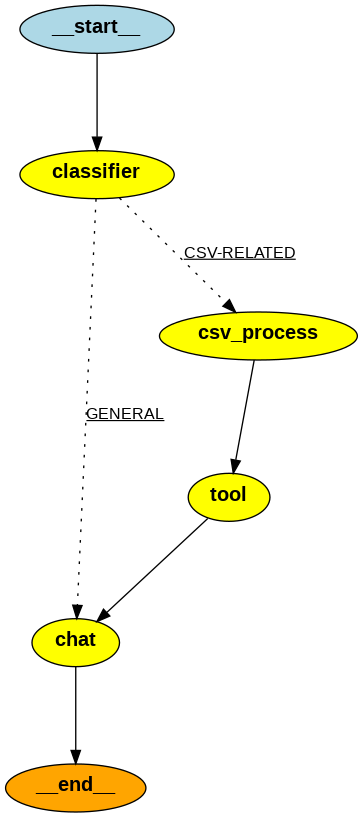

In [ ]:
from IPython.display import display, Image

png_data = graph.get_graph().draw_png()

# Convert the binary data to an IPython Image object with specific dimensions
image = Image(data=png_data)

# Display the image
display(image)